In [1]:
import f3dasm
import numpy as np
from dataclasses import dataclass
from typing import Tuple
import copy

2022-12-19 14:19:27.214115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 14:19:27.356685: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-19 14:19:28.000690: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64
2022-12-19 14:19:28.000793: W tensorflow/compiler/xla/stream

In [2]:
seed=50

In [3]:
@dataclass
class State_of_the_art_Parameters(f3dasm.OptimizerParameters):
   """Example of hyperparameters"""

   learning_rate: float = 1e-5#0.0000005 # learning rate kan aangepast worden, het lijkt er op dat we de learning rate voor elke functie moeten 
                                    # moeten aanpassen want bij de ene functie maakt een bepaalde 
                                    # learning rate extreem grote stappen en bij een andere functie 
                                    # maakt hij extreem kleine stappen. Dit komt waarschijnlijk omdat
                                    # de gradient zo enorm veel verschilt.
   b_t = 0.9 # dit getal is constant, parameter om self.m te berekenen, kan volgens de paper 0.9, 0.99 of 0.999 zijn
   

class State_of_the_art(f3dasm.Optimizer):
   """Example of implement your own optimizer"""

   parameter: State_of_the_art_Parameters = State_of_the_art_Parameters()

   def init_parameters(self):
      """Set the initialization parameters. This could be dynamic or static hyperparameters."""
      self.m: np.ndarray = np.zeros(self.data.design.get_number_of_input_parameters()) #m initialized op 0, daarna wordt hij bij elke iteratie geupdate
      self.velocity: np.ndarray = np.zeros(self.data.design.get_number_of_input_parameters())
      self.isfirstiteration = True

   def update_step(self, function: f3dasm.Function) -> Tuple[np.ndarray, np.ndarray]:
      """Custom update step for your own optimizer

      Parameters
      ----------
      function
         objective function that is being optimized

      Returns
      -------
         tuple of resulting input and output parameter
      """
    
    #Hieronder een if/else statement die checkt of het de eerste iteratie is, dan moet hij namelijk de beste sample gebruiken om verder te optimaliseren. 
    #Als het niet de eerste iteratie is, moet hij het laatste punt gebruiken om verder te optimaliseren. Het laatste punt is dan dus het geoptimaliseerde punt uit de vorige iteratie. 
      
      if self.isfirstiteration: 
        x = self.data.get_n_best_input_parameters_numpy(1)[0]
        #x = self.data.get_input_data().iloc[2].to_numpy()
        #print(x)
        self.isfirstiteration = False
      else:
        x = self.data.get_input_data().iloc[-1].to_numpy()
        #print(x)
      
      #print('input: ', self.data.get_input_data())
      #print('output: ', self.data.get_output_data())

      g = function.dfdx(x)
   
      self.m = (1-self.parameter.b_t)*g + (self.parameter.b_t*self.m)
      
      updatestep = g * np.exp(np.sign(g) * np.sign(self.m)) # de beste updaterule van de paper
    
      x_update = x - self.parameter.learning_rate * updatestep
    
      # self.m = (1-self.parameter.b_t)*g + (self.parameter.b_t*self.m)
      # updatestep = g * np.exp(np.sign(g) * np.sign(self.m)) # de beste updaterule van de paper

      # self.velocity = 0.9 * self.velocity  + self.parameter.learning_rate * function.dfdx2(x)
      # x_update = x - self.velocity
    
      # x_update = x - self.parameter.learning_rate * g
  
      
      # Format and force bounds
      x_update = np.atleast_2d(self._force_bounds(x_update))
    #   print('x_update: ', x_update)
      y_update = function(x_update)
    #   print('y_update: ', y_update)
      return x_update, y_update



In [4]:
dimensionality = 2
design = f3dasm.make_nd_continuous_design(bounds=np.array([[-2.0,2.0],[-1.,3.]]), dimensionality=dimensionality)

data = f3dasm.Data(design)
in_array = np.array([[-1.0, 2.5]])
out_array = np.array([[np.nan]])
data.add_numpy_arrays(input=in_array, output=out_array)
data.data

input      output
     x0   x1      y
0  -1.0  2.5    NaN

2022-12-19 14:19:38.145631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-19 14:19:38.145749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin): /proc/driver/nvidia/version does not exist
2022-12-19 14:19:38.148652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  input            output
     x0   x1            y
0  -1.0  2.5  1295.145185
Optimizing for 100 iterations with State_of_the_art


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: xlabel='$X_{0}$', ylabel='$X_{1}$'>)

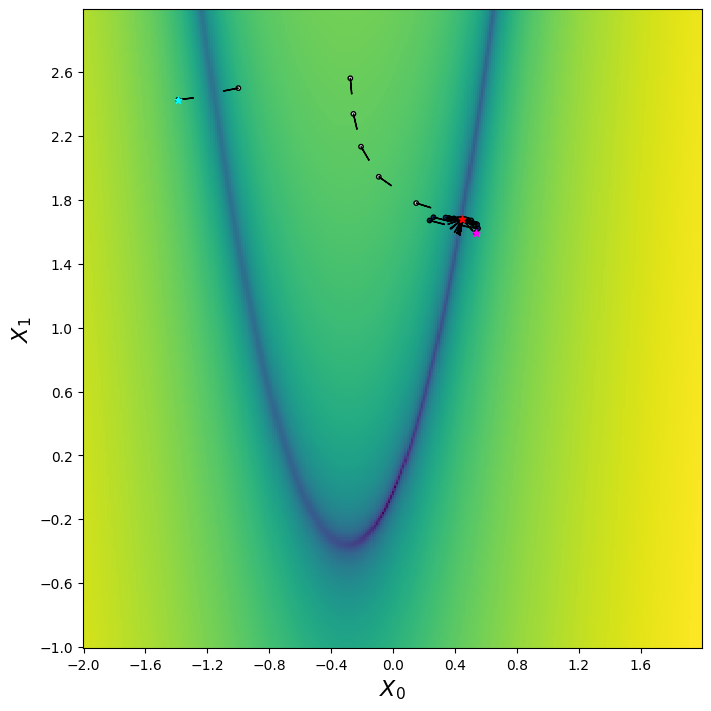

In [5]:
iterations = 100
numsamples = 1
lhs_sampler = f3dasm.sampling.LatinHypercube(design=design, seed=40)
# samples = lhs_sampler.get_samples(numsamples=numsamples) #samples hebben nu nog geen output, die wordt later toegevoegd
samples = copy.copy(data)
# samples.plot()

#print(f3dasm.functions.Rosenbrock(dimensionality=dimensionality, seed=50, scale_bounds=design.get_bounds()).get_global_minimum(dimensionality))
function = f3dasm.functions.Rosenbrock(dimensionality=dimensionality, seed=seed, scale_bounds=design.get_bounds()) #Rosenbrock functie wordt gebruikt, net zoals in de paper
samples.add_output(output=function(samples))
print(samples.data)

State_of_the_art_Optimizer = State_of_the_art(data=copy.copy(samples))
State_of_the_art_Optimizer.iterate(iterations=iterations, function=function)
State_of_the_art_Data = State_of_the_art_Optimizer.extract_data()

function.plot_data(data=State_of_the_art_Data, domain=samples.design.get_bounds(),numsamples=numsamples)

In [6]:
x_sel = samples.get_input_data().iloc[-1]

In [7]:
x_sel[0]

-1.0

In [8]:
x_sel

x0   -1.0
x1    2.5
Name: 0, dtype: float64